<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*The Deutsch-Jozsa Algorithm*_ 

The [Deutsch-Jozsa algorithm](http://rspa.royalsocietypublishing.org/content/439/1907/553) is one of the earliest examples demonstrating the power of quantum computers. Suppose Alice has a Boolean function, i.e. a function $f(x)$ that outputs either $0$ or $1$ for every input $x$. This function is called the "oracle". Furthermore, Alice promises that her function is either balanced, i.e. half of the possible inputs give $0$ and the other half give $1$, or constant, i.e. every input gives the same output. Alice has a friend Bob whose goal is to determine which type of function Alice has. To do so, he can send Alice inputs and record the output.

Classically, in the best case, two queries to the oracle can determine if the hidden Boolean function is balanced; in the worst case, at least half of the inputs must be queried to determine if the hidden Boolean function is constant for all inputs. However, using quantum mechanics, the Deutsch-Jozsa algorithm can determine the Boolean function with just one query.   

***
### Notebook Contributors
Rudy Raymond, Eric Bersin

## The Algorithm

Inputs to the oracle are given in binary, in the form of an $n$-bit string. The algorithm can be summarized as follows.
1. Prepare two quantum registers. The first is an $n$-qubit reqister that will be used as the input for the oracle. All qubits in this register will be initialized to zero. The second register is a one-qubit register that will be used to store the output of the oracle. This register should be initialized to one:
$$
|0_{n-1}0_{n-2}0_{n-3}\ldots 0_0\rangle |1\rangle
$$
2. Create the superposition of all input queries in the first register by applying the Hadamard gate to each qubit (dropping subscripts for visibility):
$$
H^{\otimes^n} |0\ldots 0\rangle |1\rangle = \frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1}|i\rangle |1\rangle 
$$

where $|i\rangle$ is the binary representation of $i$, i.e. $|i=0\rangle=|0\ldots 00\rangle$, $|i=1\rangle=|0\ldots 01\rangle$, $|i=2\rangle=|0\ldots 10\rangle$, etc.
3. Apply the Hadamard gate to the second register. This will allow us to store the value of the oracle in phase, which lets us take advantage of an effect known as interference.
$$
\frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1}|i\rangle |1\rangle \rightarrow \frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}|i\rangle ( |0\rangle - |1\rangle )
$$
4. Feed the input register to the oracle, flipping the sign of each $|i\rangle$ state conditioned on the output of $f(i)$:
$$
\frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}|i\rangle ( |0\rangle - |1\rangle ) \rightarrow \frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}(-1)^{f(i)}|i\rangle ( |0\rangle - |1\rangle ) 
$$
5. Apply the Hadamard gate to the first register

6. Measure the first register. If if is zero (i.e. if it is the binary $|000....0\rangle$), then we conclude that the oracle function is constant. If it is non-zero, then we conclude that the oracle function is balanced.

We will see how this works in the following implementation.

## Implementation

We now implement the Deutsch-Jozsa algorithm with Qiskit.

First, prepare the environment as done in previous notebooks.

In [1]:
# import Qiskit
from qiskit import BasicAer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, compile
from qiskit.tools.monitor import job_monitor

# import useful additional packages 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

/anaconda3/envs/Qiskitenv/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


Next, create the necessary quantum and classical registers.

In [2]:
# Create n+1 quantum registers and n classical registers
n = 4 # the length of the first register for querying the oracle 

# Creating registers
# n qubits for querying the oracle and one qubit for storing the answer
qr = QuantumRegister(n+1) #all qubits are initialized to zero
# b classical registers for recording the measurement on the first quantum register
cr = ClassicalRegister(n)

Create a circuit for running the Deutsch-Jozsa algorithm. First, perform initialize the qubits and perform the Hadamard gates that run before the application of the oracle function. Place a barrier at the end to demarcate the beginning of the oracle.

In [3]:
# Create the circuit and initialize the states
circuit = QuantumCircuit(qr, cr)

# the default initialization is to have all qubits in |0>; perform an X gate 
# on the storage qubit to initialize to the correct starting state
circuit.x(qr[n])

# Perform all necessary Hadamard gates
# Create the superposition of all input queries in the first register by applying the Hadamard gate to each qubit.
for i in range(n):
    circuit.h(qr[i])
    
# Apply the Hadamard gate to the storage qubit
circuit.h(qr[n])
    
# Apply barrier to mark the beginning of the oracle
circuit.barrier();

### Constant Oracle

Next, we apply the oracle. First, let's choose Alice to have a constant oracle; this should either apply the identity $(-1)^0$ or invert $(-1)^1$ every state. Place a barrier at the end to demarcate the end of the oracle.

In [4]:
# ORACLE
# Choose a constant oracle output 0 or 1; based on that, either apply the identity or flip every term in the state
oracleOutput = 0;

#if the output is constant 1, all states get a (-1) factor
if oracleOutput == 1:
    # Note that since the nth qubit is in the state |0>-|1>, performing the X gate on it is 
    # equivalent to multiplying every term in the state by -1
    circuit.x(qr[n]) 
else:
    for i in range(n):
        circuit.iden(qr[i])

# Apply barrier to mark the end of the oracle
circuit.barrier();

Lastly, perform Hadamard gates on all of the query qubits and measure their final values.

In [5]:
# Apply Hadamard gates
for i in range(n):
    circuit.h(qr[i])
    
# Measurement using the classical registers
for i in range(n):
    circuit.measure(qr[i], cr[i]);

Draw the circuit to verify that it is doing what it's supposed to be doing!

In [6]:
# Draw the circuit to verify that it looks correct
circuit.draw()

Run the circuit using the simulator.

In [7]:
# Choose a backend, choose a number of trials (shots), and execute the job
backend = BasicAer.get_backend('qasm_simulator')
shots = 1000
job = execute(circuit, backend=backend, shots=shots);

Plot a histogram of the final states to verify that the output is as expected.

/anaconda3/envs/Qiskitenv/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


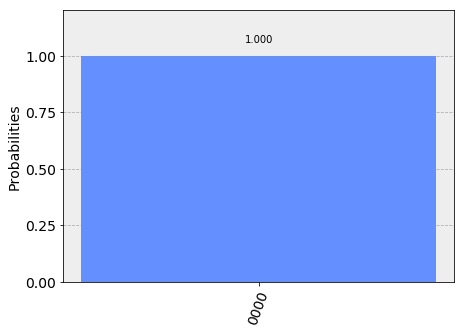

In [8]:
# Grab the result of the job, get the answers from all of the trials, and plot a histogram
results = job.result() 
answer = results.get_counts()
plot_histogram(answer)

### Balanced Oracle

Next, repeat the process, but this time with an oracle that is balanced. It's a bit tricky to figure out the circuit representation of such an oracle, so here's a hint: given that the "storage" qubit is in the $|-\rangle$ state, can you think of a gate that will flip exactly half of the terms in our state?

Once you figure that out, what happens if next you apply the same gate, but another randomly selected half of the terms?

In [9]:
# Create the circuit, initialize the qubits, and apply the Hadamard gates
circuit = QuantumCircuit(qr, cr)
circuit.x(qr[n])
for i in range(n):
    circuit.h(qr[i])

circuit.h(qr[n])
circuit.barrier()

# ORACLE
# Apply a gate that will flip exactly half of the terms in our state

# Since the storage qubit is in |->, if we apply a CX where the control is a query bit and the X is applied to
# the storage bit, we will flip exactly half our states! In fact, if we continue to apply CX gates on the storage
# bit but using other query bits as our control, we find that this continues to be the case, as each time a 
# different half of terms is flipped. This allows for generation of an arbitrary balanced oracle. In our case, 
# we make a random parameter that will determine how many CX's get applied, and on which bits; as long as
# at least one CX is applied, this process will correspond to a balanced oracle
a = np.random.randint(1,2**n) 
for i in range(n):
    if (a & (1 << i)):
        circuit.cx(qr[i], qr[n])              
circuit.barrier()

# Apply the final Hadamard gates
for i in range(n):
    circuit.h(qr[i])

# Measure the final states
for i in range(n):
    circuit.measure(qr[i], cr[i])

# Draw the circuit
circuit.draw()

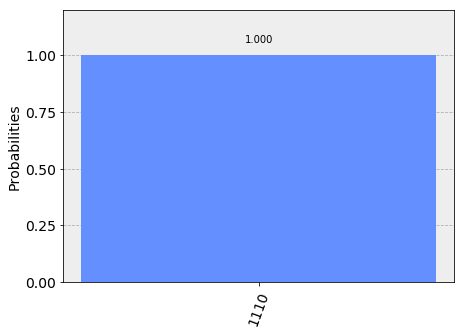

In [10]:
# Choose backend, choose number of trials, execute job, grab results/counts, and plot
backend = BasicAer.get_backend('qasm_simulator')
shots = 1000
job = execute(circuit, backend=backend, shots=shots)
results = job.result() 
answer = results.get_counts()
plot_histogram(answer)

What do you notice about the statistical distribution of the final states?

This result of this circuit is NOT probabilistic! For a given oracle, we will retrieve the same state each and every time, meaning we only need to run the algorithm once to determine the nature of Alice's hidden function. This is a key facet of quantum computing: while quantum mechanics is inherently probabilistic, a well-designed quantum algorithm will produce a single final state, such that the final measurement is in fact deterministic. This is possible due to the phenomenon of interference, whereby terms in the state will destructively interfere - i.e., positive and negative terms will cancel out - for states that correspond to the wrong answer, and they will positive interfere for states taht correspond to the correct answer.

Can you garner any intuition about why this works? It's easiest to start by looking at the constant oracle case - what's going on with the circuit that results in the output being $|00...0\rangle$ no matter what? From there, what changes about the balanced case that guarantees an non-zero output?

The magic of the algorithm can be understood as follows:

When the hidden oracle function is constant, the quantum states before and after querying the oracle are the same. The inverse of the Hadamard gate is the Hadamard gate itself. Thus, we essentially reverse the first set of Hadamard gates to obtain the initial quantum state of all-zero in the first register.

When the hidden oracle function is balanced, the quantum state after querying the oracle is orthogonal to the quantum state before querying the oracle. Thus, when reverting the operation, we must end up with a quantum state that is orthogonal to the initial quantum state of all-zero at the first register. This means we should never obtain the all-zero state.